<a href="https://colab.research.google.com/github/sidtYson/aweekwith/blob/master/Demo_Reverse_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal**

We will create a reverse image search engine

**Technique**

dense feature representation of an image

***Why?***

<img src="https://i.stack.imgur.com/h8YGK.jpg">




In [ ]:
! pip install bing-image-downloader


In [ ]:
from pathlib import Path
dataset_dir = Path("dataset")
dataset_dir.mkdir(exist_ok=True)

In [ ]:
# script - only run once

from bing_image_downloader import downloader

classes = ["bus", "dog", "cat", "bus", "train"]
NO_IMAGES = 20

for c in classes:
  downloader.download(c, limit=NO_IMAGES,  output_dir=str(dataset_dir), adult_filter_off=True, force_replace=False, timeout=60)

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Model

from tensorflow.keras.preprocessing import image

This is our vgg 16 model

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png"> </img>

In [ ]:
from PIL import Image
import numpy as np

In [166]:
# test

# base_model = VGG16(weights="imagenet") # getting model

# base_model.get_config() # loading config

# # load image
# img = Image.open(dataset_dir/'bus'/'Image_1.jpg')
# x = preprocess(img)
# assert m.predict(x)[0].shape[0] == 4096
# m = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
# m.predict(x)[0].mean()

In [142]:
class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights="imagenet")
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        x = self.preprocess(img)
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)
    
    def preprocess(self, img):
        img = img.resize((224, 224))
        img = img.convert('RGB')
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return x


In [ ]:
# rename as not unique
for i, image_path in enumerate(dataset_dir.glob("**/*.jpg")):
    target = dataset_dir / f"Image{(i+1)}.jpg"
    image_path.rename(target)

In [ ]:
fe = FeatureExtractor()
FEATURE_DIR = Path("features")
FEATURE_DIR.mkdir(exist_ok=True)

In [ ]:
for image_path in dataset_dir.glob("*.jpg"):
    img = Image.open(image_path)
    feature = fe.extract(img)
    feature_path = FEATURE_DIR / f"{image_path.stem}.npy"
    assert m.predict(x)[0].shape[0] == 4096
    np.save(feature_path, feature)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
assert np.load(feature_path).shape[0] == 4096

In [ ]:
image_paths = []
features = []

for feature_path in FEATURE_DIR.glob("*.npy"):
    features.append(np.load(feature_path))
    image_paths.append(f"{feature_path.stem}.jpg")
features = np.array(features)

In [ ]:
assert len(features) == len(image_paths)

In [181]:
def get_top_n(query_image_path, n=3):
    query = Image.open(query_image_path)
    query_features = fe.extract(query)
    assert query_features.shape[0] == 4096
    dists = np.linalg.norm(features-query_features, axis=1) # this is the most computation heavy process
    ids = np.argsort(dists)[:n]
    maximum = dists.max()
    outputs = [(dists[id]/maximum, image_paths[id]) for id in ids]
    return outputs

In [191]:
from google.colab import files
image = files.upload()

Saving 1JDnxomb.jpg to 1JDnxomb.jpg


In [198]:
query_path = list(image.keys())[0]

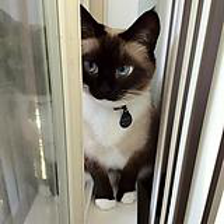

In [185]:
show('cat.jpg')

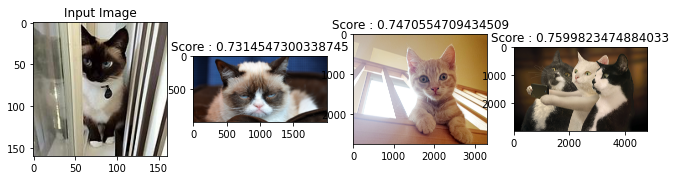

In [187]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

query_image_path = "cat.jpg"
# get top 3 results
outputs = get_top_n(query_image_path)

# figure size in inches optional
rcParams['figure.figsize'] = 11, 8

# display images
fig, ax = plt.subplots(1, 4)

ax[0].imshow(mpimg.imread(query_image_path))
ax[0].set_title("Input Image")

for i, output in enumerate(outputs):
    score, image_path = output
    ax[i+1].imshow(mpimg.imread(dataset_dir / image_path))
    ax[i+1].set_title(f"Score : {score}")